# Using python to analyse data from the Highways England WebTRIS API

Python is a free and powerful tool that can be used for transport analysis and modelling. This example demonstrates

* Fetching traffic data from an API
* Visualising the data with time series plots
* Forecasting future traffic
* Calculating a performance metric - percentage of time the road is congested

Feel free to use and adapt this code for your own purposes

### Python libraries used

| Library | Description |
|---------|:-------------|
|[datetime](https://docs.python.org/3/library/datetime.html)|python standard library for dealing with dates and times
|[pandas](https://pandas.pydata.org/)|the main library used for data analysis in Python
|[NumPy](http://www.numpy.org/)|some mathematic functions are used
|[requets](http://docs.python-requests.org/en/master/)|fetching data from the internet/API's
|[Plotly](https://plot.ly/python/)|interactive graphs
|[seaborn](https://seaborn.pydata.org/index.html)|statistical graphs
|[Folium](http://python-visualization.github.io/folium/)|interactive maps
|[Prophet](https://facebookincubator.github.io/prophet/)|Facebook's in-house forecasting software that has been released as open source and provides reasonable forecasts with no manual effot


In [20]:
import datetime
import requests
import pandas as pd
import numpy as np
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import folium
from fbprophet import Prophet

% matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

## Get the data using the webtris API
The following functions fetch data for a given site. You can view all the sites on the [WebTRIS website](http://webtris.highwaysengland.co.uk/) and read about the [API here](http://webtris.highwaysengland.co.uk/api/swagger/ui/index).

The API endpoint used returns data in 15-minute intervals and can be many pages long if you select a large time frame, a loop is used to iterate through the pages.

In [2]:
def site_info(site_id):
    """Returns a dictionary giving info on the specified site"""
    r = requests.get('http://webtris.highwaysengland.co.uk/api/v1.0/sites/' +
                     str(site_id))
    return(r.json()['sites'][0])

def site_data(site , start_date, end_date ):
    """Returns a pandas dataframe containing traffic data in 15 minute chunks.
    Dates are string of the format ddmmyyyy"""
    more_pages = True
    page_num = 1
    data = []
    # Need to go through many pages. The returned json has a nextPage item if
    # there is anothe page to collect
    while more_pages:
        r = requests.get('http://webtris.highwaysengland.co.uk/api/v1.0/reports/daily',
                         params = {'sites': str(site),
                                   'start_date': start_date,
                                   'end_date': end_date,
                                   'page': page_num,
                                   'page_size': 20000}) # 20000 data points per page
        json_response = r.json()
        invalid_response = 'Report Request Invalid. Please ensure all parameters are valid in line with API documentation.'
        if json_response == invalid_response:
            raise Exception('The API did not return any data. Check the site has data for the given dates' +
                            'and the arguments were supplied correctly. ' +
                            'Dates should be given as a string in ddmmyyyy format')
        for item in json_response['Rows']:
            data.append(item)
        print('Fetched ' + str(len(data)) + ' data points')
        page_num += 1
        links = [item['rel'] for item in json_response['Header']['links']]
        more_pages = 'nextPage' in links
        
    df = pd.DataFrame(data)
    # Make blanks -99, fill in later
    df = df.apply(lambda x: np.where(x == '', '-99', x))
    df_clean = pd.DataFrame({
        'Date': pd.to_datetime(df['Report Date']),
        'SiteId': site,
        'TotalFlow':  df['Total Volume'].astype(int),
        'LargeVehicleFlow': df['1160+ cm'].astype(int),
        'AverageSpeedMPH': df['Avg mph'].astype(int)
        })
    # Work out the start and end time of the period
    def extract_time_delta(str_time):
        hour = int(str_time.split(':')[0])
        minute = int(str_time.split(':')[1])
        offset = pd.Timedelta(hours = hour, minutes = minute)
        return(offset)
    
    mins_offset = [extract_time_delta(x) for x in df['Time Period Ending']]
    df_clean['EndTime'] = df_clean['Date'] + mins_offset
    df_clean['StartTime'] = df_clean['EndTime'] - pd.Timedelta(minutes = 15)
    # Make nans explicit
    df_clean.loc[df_clean['TotalFlow'] == -99 , 'TotalFlow'] = np.nan
    df_clean.loc[df_clean['LargeVehicleFlow'] == -99 , 'LargeVehicleFlow'] = np.nan
    df_clean.loc[df_clean['AverageSpeedMPH'] == -99 , 'AverageSpeedMPH'] = np.nan
    return(df_clean)

Here I choose a site id near Heathrow airport that I know has lots of data available.

In [3]:
site = 9006
start_date = '01012008' # 01 Jan 2008
end_date = '31122016' # 31 Dec 2016

In [4]:
my_site = site_info(site)
my_site

{'Description': '6180/1',
 'Id': '9006',
 'Latitude': 51.4480857515236,
 'Longitude': -0.450825028382527,
 'Name': 'TMU Site 6180/1 on link A30 eastbound between B378 and A315; GPS Ref: 507750;173260; Eastbound',
 'Status': 'Active'}

Folium is used to display the location of the site. Clicking the point gives some details

In [22]:
lat = my_site['Latitude']
lon = my_site['Longitude']
my_map = folium.Map(location=[lat, lon], zoom_start=13)
folium.Marker([lat, lon], popup = my_site['Name']).add_to(my_map)
my_map

I am happy with the chosen site and fetch the data for my given time range.

In [6]:
 df = site_data(site, start_date, end_date)

Fetched 20000 data points
Fetched 40000 data points
Fetched 60000 data points
Fetched 80000 data points
Fetched 100000 data points
Fetched 120000 data points
Fetched 120760 data points


In [7]:
df.tail() # View the last few rows of the dataset

AverageSpeedMPH       Date  LargeVehicleFlow  SiteId  TotalFlow  \
120755             40.0 2016-12-31               2.0    9006       45.0   
120756             40.0 2016-12-31               2.0    9006       49.0   
120757             41.0 2016-12-31               0.0    9006       39.0   
120758             40.0 2016-12-31               1.0    9006       28.0   
120759             41.0 2016-12-31               0.0    9006       30.0   

                   EndTime           StartTime  
120755 2016-12-31 22:59:00 2016-12-31 22:44:00  
120756 2016-12-31 23:14:00 2016-12-31 22:59:00  
120757 2016-12-31 23:29:00 2016-12-31 23:14:00  
120758 2016-12-31 23:44:00 2016-12-31 23:29:00  
120759 2016-12-31 23:59:00 2016-12-31 23:44:00

## View the traffic flow over time

Plotly is used to view the traffic flow in 15 minute intervals.
I have taken a subset of 1 year of data (2014) to make the plot manageable and use the plotly rangeslider to make the visualisation clearer.

In [8]:
year_start = '2014-01-01'
year_end = '2014-12-31'
one_year = df[(df.StartTime >= year_start) & (df.StartTime <= year_end)]
plot_data = [go.Scatter(x=one_year.StartTime, y=one_year.TotalFlow)]

layout = dict(
    xaxis=dict(
        rangeslider=dict(),
        type='date',
        range = ['2014-04-23','2014-05-09']),
    yaxis=dict(title='15 minute traffic flow'),
    title='15 minute traffic flow')
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

You can see the data is periodic with a peak in the AM and PM plus the traffic being quiter at weekends.

To reduce the data size I aggregate to daily flows using the pandas groupyby function

In [9]:
daily_flow = df.groupby('Date')['TotalFlow'].sum()
plot_data = [go.Scatter(x=daily_flow.index, y=daily_flow)]
layout = dict(
    title='Daily traffic flow')
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

You can see there is 8 years of data which will allow us to do long term forecasting.  There are days where the traffic drops to zero per day, presumably due to sensors being offline. These data points can be removed before forecasting. The prophet forecasting library automatically handles missing data well. Finally we have to convert the data into a dataframe with columns 'ds' and 'y' as this is the format the library requires.

In [10]:
data_prophet = daily_flow[daily_flow > 2500].reset_index()
data_prophet.columns = ['ds', 'y']

## Forecast future daily flow

Simply use the prohpet packages on default and foreast daily traffic, i have chosen to forecast 4 years ahead.

In [11]:
m = Prophet()
m.fit(data_prophet)
future = m.make_future_dataframe(periods=365*4)
forecast = m.predict(future)
forecast.head() # View the top few rows

ds         t         trend  seasonal_lower  seasonal_upper  \
0 2008-01-01  0.000000  12980.583763    -1594.994981    -1594.994981   
1 2008-01-02  0.000304  12979.445327    -1272.832800    -1272.832800   
2 2008-01-03  0.000608  12978.306891    -1147.755552    -1147.755552   
3 2008-01-04  0.000913  12977.168455    -1174.114606    -1174.114606   
4 2008-01-05  0.001217  12976.030018    -4717.266281    -4717.266281   

    trend_lower   trend_upper    yhat_lower    yhat_upper       weekly  \
0  12980.583763  12980.583763  10192.519698  12631.061813  1115.314504   
1  12979.445327  12979.445327  10433.749154  13019.082754  1403.502369   
2  12978.306891  12978.306891  10576.549358  13182.281809  1471.128730   
3  12977.168455  12977.168455  10510.599540  13003.282920  1365.352713   
4  12976.030018  12976.030018   6936.594481   9499.698343 -2277.290229   

   weekly_lower  weekly_upper       yearly  yearly_lower  yearly_upper  \
0   1115.314504   1115.314504 -2710.309485  -2710.309485  -2710.309485   
1   1403.502369   1403.502369 -2676.335169  -2676.335169  -2676.335169   
2   1471.128730   1471.128730 -2618.884282  -2618.884282  -2618.884282   
3   1365.352713   1365.352713 -2539.467319  -2539.467319  -2539.467319   
4  -2277.290229  -2277.290229 -2439.976053  -2439.976053  -2439.976053   

      seasonal          yhat  
0 -1594.994981  11385.588782  
1 -1272.832800  11706.612526  
2 -1147.755552  11830.551339  
3 -1174.114606  11803.053848  
4 -4717.266281   8258.763737

The resulting forecast is a dataframe with many columns, each of which are explained in the documentation on the prophet website. The most important is yhat which is the forecast - daily traffic in our case. Lets plot this



In [23]:
forecast_data = forecast.loc[forecast.ds > data_prophet.ds.max(), ['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
historic = go.Scatter(x=data_prophet.ds, y=data_prophet.y, name='Historic daily flow')
forecasted = go.Scatter(x=forecast_data.ds, y=forecast_data.yhat, name='Forecast daily flow')
plot_data = [historic,  forecasted]
layout = dict(title='Daily traffic foreast')
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

The forecat includes confidence intervals (95% by default). Lets plot these and zoom in a bit.

In [24]:
upper_forecast = go.Scatter(x=forecast_data.ds, y=forecast_data.yhat_upper, 
                            name='Prediction interval', fill= 'tonexty', line=dict(width=0.0))
lower_forecast = go.Scatter(x=forecast_data.ds, y=forecast_data.yhat_lower, 
                            name='', fill= None, line=dict(width=0.0))
plot_data = [forecasted, lower_forecast, upper_forecast ]

layout = dict(
    title='Forecast with prediction intervals',
    xaxis=dict(
        rangeslider=dict(),
        type='date',
        range = ['2017-01-01','2017-03-01']))
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

### Components of the forecast

The forecast output includes various time series components of the forecast that can be examined.
Lets plot the overall trend after the seasonal components have been removed

In [14]:
trend = go.Scatter(x=forecast.ds, y=forecast.trend, name='Daily flow trend')
trend_lower = go.Scatter(x=forecast.ds, y=forecast.trend_lower, 
                         name='', fill= None, line=dict(width=0.0))
trend_upper = go.Scatter(x=forecast.ds, y=forecast.trend_upper, 
                         name='Prediction interval', fill= 'tonexty', line=dict(width=0.0))
plot_data = [trend, trend_lower, trend_upper]
layout=dict(title='Time series decomposition: trend')
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

You can see the size of the prediction interval increases as you go further into the future.

Lets plot the weekly and monthly seasonal components

In [15]:
forecast['day_of_week'] = forecast.ds.apply(lambda x: x.weekday())
daily_trend = forecast.groupby('day_of_week')['weekly'].mean()
plot_data = [go.Bar(x=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'], y=daily_trend.values)]
layout=dict(title='Time series decomposition: weekly')
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

In [16]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
forecast['month'] = forecast.ds.apply(lambda x: months[x.month-1])
yearly_trend = forecast.groupby('month')['yearly'].mean().reindex(months)
plot_data = [go.Bar(x=yearly_trend.index.values, y=yearly_trend.values)]
layout=dict(title='Time series decomposition: monthly')
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

As expected, the traffic is less at the weekends and over the Dec-Jan period when people are on winter holidays. Interestingly the traffic is higher for Jun and Jul summer holiday period, presumably as people and staff travel to the nearby airpoty during the summer holiday season.

The prophet library provides a reasonable looking forecast without any manual effort. You could improve on the forecast using your own ARIMA and/or regression model. [The forecasting principles and practice book](https://www.otexts.org/fpp) is a good place to start learning more. You may want to increase the granularity and produce hourly or 15 minute interval forecasts instead of daily ones.

# Congestion
For some sites the API data includes both speed and flow data. Here I use seaborn to ploy the Speed Flow curve (seaborn adds the historgrams on the x and y axis).

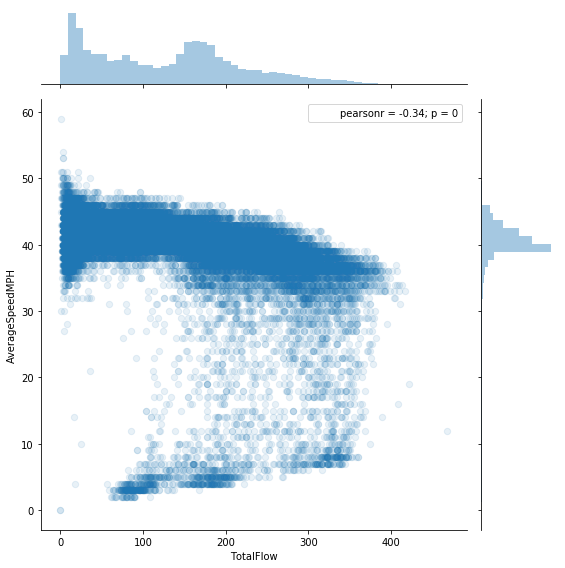

In [21]:
sns.jointplot(x="TotalFlow", y="AverageSpeedMPH", data=df, alpha = 0.1, s = 40, size = 8) # The alpha parameter makes points transparent which is useful as there are so many points

At around 30 to 50 mph the data follows a straight line correlation with a greater flow of cars per 15 minutes leading to a slower average speed. The relationship makes sense as drivers will slow down when more cars are around them.

There are also outlier points below ~25mph that do not fit the above pattern. One explanaition is that the traffic is congested at these times. We can use this insight to calculate the percentage of time that the road is congested.

In [18]:
congestion_speed = 25.0
congested_points = (df.AverageSpeedMPH < congestion_speed).sum()
total_points = df.AverageSpeedMPH.notnull().sum()
print(str(round(congested_points/total_points * 100, 1)) + '%' +
     ' out of the ' + str(total_points) +  ' data points (15 minute intervals) are congested')

2.9% out of the 58623 data points (15 minute intervals) are congested


Has the congestion changed over time?

In [19]:
df['year'] = df.StartTime.apply(lambda x: x.year)
df['month'] = df.StartTime.apply(lambda x: x.month)
total_points_per_month = df.groupby(['year', 'month'])['AverageSpeedMPH'].apply(lambda x: x.notnull().sum())
congested_points_per_month = df.groupby(['year', 'month'])['AverageSpeedMPH'].apply(lambda x: (x < congestion_speed).sum())
df_congestion = (congested_points_per_month / total_points_per_month * 100).reset_index().sort_values(['year', 'month'])
df_congestion['month'] = df_congestion.month.apply(lambda x: months[x-1])
df_congestion['date'] = df_congestion.apply(lambda row: str(row.month) + '-' + str(row.year), axis=1)
df_congestion = df_congestion.rename(columns={'AverageSpeedMPH': 'PercentCongested'})
df_congestion = df_congestion[df_congestion.PercentCongested.notnull()]
plot_data = [go.Scatter(x=df_congestion.date, y=df_congestion.PercentCongested)]
layout = dict(
    title='Percentage congested over time',
    xaxis=dict(range = ['2014-01-01','2017-01-01']),
    yaxis=dict(title='%'))
fig = dict(data=plot_data, layout=layout)
plotly.offline.iplot(fig)

Perhaps there were some roadworks around Jan 2016?